jupyter-lab --allow-root --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

In [1]:
import tensorflow as tf
devices = tf.config.list_physical_devices()
print(devices)
tf.debugging.set_log_device_placement(True)
a=tf.random.normal([100,100])
b=tf.random.normal([100,100])
c = a*b

AttributeError: ignored

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import r2_score

from tensorflow import keras
from keras import layers
from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.models import Sequential,load_model,save_model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam

2023-06-28 15:35:20.194729: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Age Estimation

In [2]:
# image_dir = Path('/content/drive/MyDrive/AI/.kaggle/20-50') #tell python in which directory the training images are.
image_dir = Path('/Users/crossrunway/DataSets/20-50')

In [3]:
filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
ages = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Age').astype(np.int32)

images = pd.concat([filepaths, ages], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)


In [4]:
image_df = images.sample(20000, random_state=1).reset_index(drop=True)

train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [5]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [6]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath', # kepek
    y_col='Age', # becsülendő életkorok
    target_size=(64,64), # egy kép mérete
    color_mode='rgb', # 3 csatornás képek, RGB
    class_mode='raw', # mivel a célváltozónk int típusú és nem object
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(64,64),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(64,64),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 11200 validated image filenames.
Found 2800 validated image filenames.
Found 6000 validated image filenames.


In [7]:
from PIL import Image

inputs = tf.keras.Input(shape=(64,64, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

age_model = tf.keras.Model(inputs=inputs, outputs=outputs)

age_model.compile(
    optimizer='adam',
    loss='mse'
)

history = age_model.fit(
    train_images,
    validation_data=val_images,
    epochs=50
    ,callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50


2023-06-28 15:35:38.154130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


350/350 [==============================] - ETA: 0s - loss: 338.9465

2023-06-28 15:35:54.520052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


350/350 [==============================] - 19s 52ms/step - loss: 338.9465 - val_loss: 188.7515
Epoch 2/50
350/350 [==============================] - 13s 38ms/step - loss: 191.1795 - val_loss: 185.7935
Epoch 3/50
350/350 [==============================] - 13s 37ms/step - loss: 191.4606 - val_loss: 186.8748
Epoch 4/50
350/350 [==============================] - 13s 37ms/step - loss: 190.6307 - val_loss: 186.5584
Epoch 5/50
350/350 [==============================] - 13s 38ms/step - loss: 189.7463 - val_loss: 192.1472
Epoch 6/50
350/350 [==============================] - 13s 37ms/step - loss: 190.6008 - val_loss: 184.2639
Epoch 7/50
350/350 [==============================] - 13s 38ms/step - loss: 190.4782 - val_loss: 186.7639
Epoch 8/50
350/350 [==============================] - 13s 38ms/step - loss: 188.6994 - val_loss: 188.8612
Epoch 9/50
350/350 [==============================] - 13s 38ms/step - loss: 191.0125 - val_loss: 183.8778
Epoch 10/50
350/350 [==============================] - 14

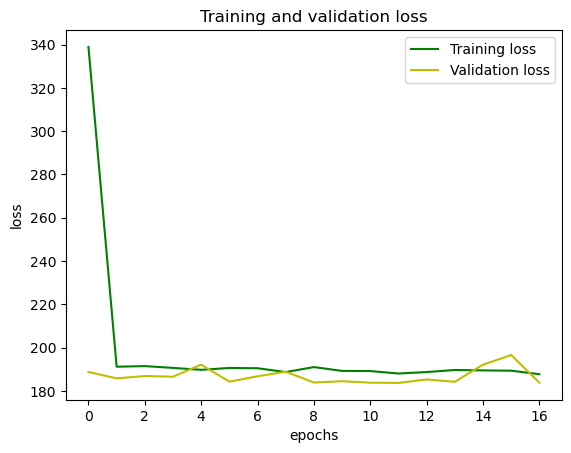

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=0)
plt.figure()
plt.show()

Gender Estimation

In [13]:
train_datagen = ImageDataGenerator(rescale = 1./255,
      rotation_range=25,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [14]:
batch_size = 64
target_size = (64, 64)
input_shape=(64, 64, 3)
seed=1337
adam = 0.001
fre= -20
FC = 2048
E = 1
patience = 3
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch=256
validation_steps=256
epochs=10

In [15]:
test_datagen = ImageDataGenerator( rescale = 1.0/255)

train_generator = train_datagen.flow_from_directory('/Users/crossrunway/DataSets/Dataset/Train',
                                                    batch_size =batch_size ,
                                                    class_mode = 'binary',
                                                    seed=seed,
                                                    target_size = target_size )

validation_generator =  test_datagen.flow_from_directory( '/Users/crossrunway/DataSets/Dataset/Validation',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary',
                                                          seed=seed,
                                                          target_size = target_size)

Found 160000 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.


In [16]:
base_model = tf.keras.applications.VGG16(input_shape=input_shape,include_top=False,weights="imagenet")

In [17]:
for layer in base_model.layers[:fre]:
    layer.trainable=False

In [18]:
# Building Model
model=Sequential()
model.add(base_model)
model.add(layers.Dropout(.2))

model.add(Conv2D(512, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(128, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(500, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,strides=(2,2), padding='same'))



# Add new layers
model.add(Flatten())
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(FC, activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(E, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 2, 2, 512)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 512)         2359808   
                                                                 
 batch_normalization (BatchN  (None, 2, 2, 512)        2048      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 512)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 128)         589952    
                                                        

In [19]:
model.compile(optimizer=Adam(adam),
              loss='binary_crossentropy'
              ,metrics=['accuracy'])

In [20]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                        patience = patience,
                        verbose = verbose ,
                        factor = factor,
                        min_lr = min_lr)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=verbose, patience=patience)

In [21]:
%time
hist = model.fit_generator(generator=train_generator,
                           validation_data=validation_generator,
                           steps_per_epoch=steps_per_epoch,
                           validation_steps=validation_steps,
                           epochs=epochs,
                           callbacks=[lrd, mcp, es])

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 10.3 µs


/var/folders/mp/4941wy2j1n5_72tw28nm76d40000gn/T/ipykernel_88336/1157127437.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(generator=train_generator,


Epoch 1/10


2023-06-28 15:41:02.426989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


256/256 [==============================] - ETA: 0s - loss: 0.6537 - accuracy: 0.6501

2023-06-28 15:51:16.677258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


256/256 [==============================] - 757s 3s/step - loss: 0.6537 - accuracy: 0.6501 - val_loss: 0.9883 - val_accuracy: 0.5701 - lr: 0.0010
Epoch 2/10
256/256 [==============================] - 771s 3s/step - loss: 0.3717 - accuracy: 0.8433 - val_loss: 0.3472 - val_accuracy: 0.8752 - lr: 0.0010
Epoch 3/10
256/256 [==============================] - 783s 3s/step - loss: 0.2682 - accuracy: 0.8932 - val_loss: 0.1698 - val_accuracy: 0.9305 - lr: 0.0010
Epoch 4/10
256/256 [==============================] - 765s 3s/step - loss: 0.2288 - accuracy: 0.9066 - val_loss: 0.1822 - val_accuracy: 0.9368 - lr: 0.0010
Epoch 5/10
256/256 [==============================] - 751s 3s/step - loss: 0.1995 - accuracy: 0.9215 - val_loss: 0.1650 - val_accuracy: 0.9401 - lr: 0.0010
Epoch 6/10
256/256 [==============================] - 767s 3s/step - loss: 0.1918 - accuracy: 0.9238 - val_loss: 0.3310 - val_accuracy: 0.8715 - lr: 0.0010
Epoch 7/10
256/256 [==============================] - 817s 3s/step - loss: 

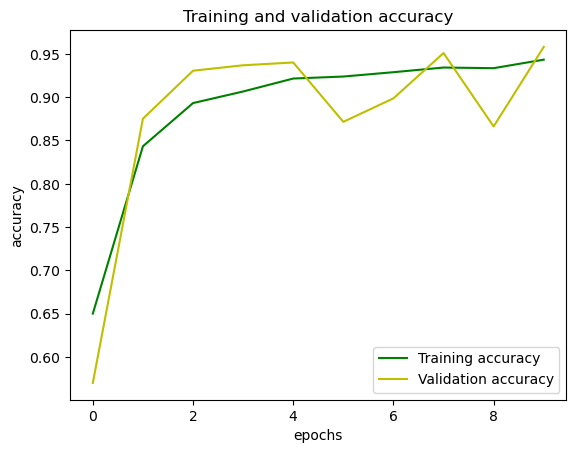

<Figure size 640x480 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

After Train

In [23]:
import numpy as np

predicted_ages = np.squeeze(age_model.predict(test_images))
true_ages = test_images.labels

rmse = np.sqrt(age_model.evaluate(test_images, verbose=0))
print("     Test RMSE: {:.5f}".format(rmse))

r2 = r2_score(true_ages, predicted_ages)
print("Test R^2 Score: {:.5f}".format(r2))

  1/188 [..............................] - ETA: 33s

2023-06-28 17:50:35.814547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


188/188 [==============================] - 8s 43ms/step


2023-06-28 17:50:44.202837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


     Test RMSE: 13.51511
Test R^2 Score: 0.00815


In [24]:
null_rmse = np.sqrt(np.sum((true_ages - np.mean(true_ages))**2) / len(true_ages))
print("Null/Baseline Model Test RMSE: {:.5f}".format(null_rmse))

Null/Baseline Model Test RMSE: 13.57050


1/1 [==============================] - 0s 314ms/step


This  is a female
Predicted: 37
Actual: 40


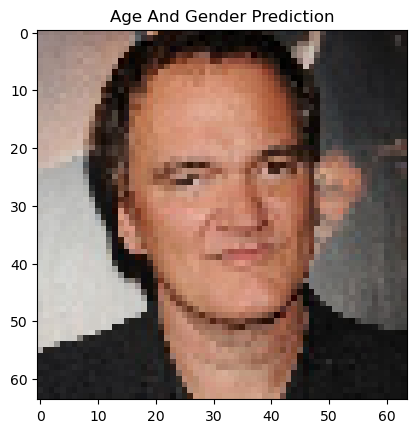

In [25]:
import matplotlib.pyplot as plt

path_testmodel = "/Users/crossrunway/DataSets/test/test1.jpg"
imge = tf.keras.preprocessing.image.load_img(path_testmodel, target_size=(64,64))

input_arr = np.array([tf.keras.preprocessing.image.img_to_array(imge)]).astype('float32') / 255
predictions = age_model.predict(input_arr)

X = tf.keras.utils.img_to_array(imge)
X = np.expand_dims(X, axis=0)
images = np.vstack([X])
classes = model.predict(images, batch_size=1)
if classes[0]>0.5:
    print("\n\nThis is a male")
else:
    print("\n\nThis  is a female")
plt.imshow(imge)

predicted_age = predictions[0][0].astype(np.int32).astype(str)
actual_age = str(40)

plt.title("Age And Gender Prediction")

print('Predicted: ' + predicted_age + '\n' +
         'Actual: ' + actual_age )

1/1 [==============================] - 0s 42ms/step


This  is a female
Predicted: 36
Actual: 35


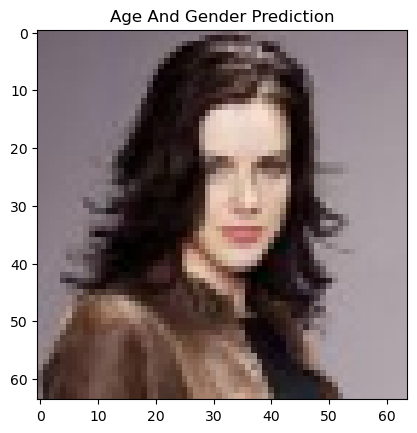

In [26]:
import matplotlib.pyplot as plt

path_testmodel = "/Users/crossrunway/DataSets/test/test2.jpg"
imge = tf.keras.preprocessing.image.load_img(path_testmodel, target_size=(64,64))

input_arr = np.array([tf.keras.preprocessing.image.img_to_array(imge)]).astype('float32') / 255
predictions = age_model.predict(input_arr)

X = tf.keras.utils.img_to_array(imge)
X = np.expand_dims(X, axis=0)
images = np.vstack([X])
classes = model.predict(images, batch_size=1)
if classes[0]>0.5:
    print("\n\nThis is a male")
else:
    print("\n\nThis  is a female")
plt.imshow(imge)

predicted_age = predictions[0][0].astype(np.int32).astype(str)
actual_age = str(35)

plt.title("Age And Gender Prediction")

print('Predicted: ' + predicted_age + '\n' +
         'Actual: ' + actual_age )

1/1 [==============================] - 0s 41ms/step


This  is a female
Predicted: 33
Actual: 30


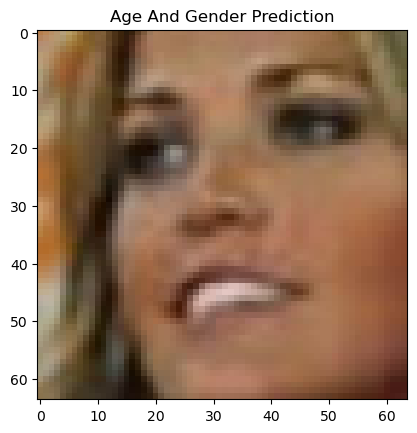

In [27]:
import matplotlib.pyplot as plt

path_testmodel = "/Users/crossrunway/DataSets/test/test3.jpg"
imge = tf.keras.preprocessing.image.load_img(path_testmodel, target_size=(64,64))

input_arr = np.array([tf.keras.preprocessing.image.img_to_array(imge)]).astype('float32') / 255
predictions = age_model.predict(input_arr)

X = tf.keras.utils.img_to_array(imge)
X = np.expand_dims(X, axis=0)
images = np.vstack([X])
classes = model.predict(images, batch_size=1)
if classes[0]>0.5:
    print("\n\nThis is a male")
else:
    print("\n\nThis  is a female")
plt.imshow(imge)

predicted_age = predictions[0][0].astype(np.int32).astype(str)
actual_age = str(30)

plt.title("Age And Gender Prediction")

print('Predicted: ' + predicted_age + '\n' +
         'Actual: ' + actual_age )

1/1 [==============================] - 0s 40ms/step


This  is a female
Predicted: 35
Actual: 38


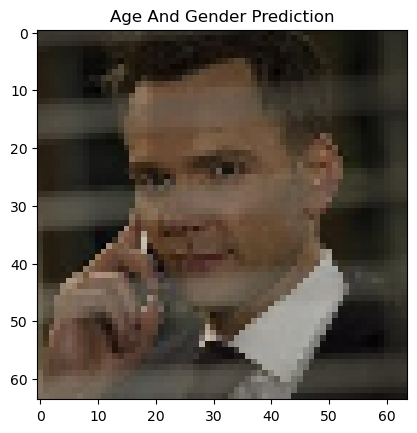

In [28]:
import matplotlib.pyplot as plt

path_testmodel = "/Users/crossrunway/DataSets/test/test4.jpg"
imge = tf.keras.preprocessing.image.load_img(path_testmodel, target_size=(64,64))

input_arr = np.array([tf.keras.preprocessing.image.img_to_array(imge)]).astype('float32') / 255
predictions = age_model.predict(input_arr)

X = tf.keras.utils.img_to_array(imge)
X = np.expand_dims(X, axis=0)
images = np.vstack([X])
classes = model.predict(images, batch_size=1)
if classes[0]>0.5:
    print("\n\nThis is a male")
else:
    print("\n\nThis  is a female")
plt.imshow(imge)

predicted_age = predictions[0][0].astype(np.int32).astype(str)
actual_age = str(38)

plt.title("Age And Gender Prediction")

print('Predicted: ' + predicted_age + '\n' +
         'Actual: ' + actual_age )

1/1 [==============================] - 0s 46ms/step


This  is a female
Predicted: 38
Actual: 24


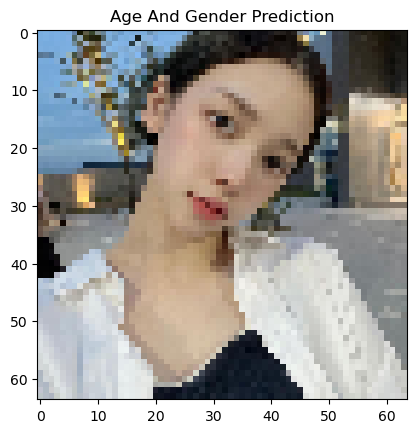

In [29]:
import matplotlib.pyplot as plt

path_testmodel = "/Users/crossrunway/DataSets/test/test5.jpeg"
imge = tf.keras.preprocessing.image.load_img(path_testmodel, target_size=(64,64))

input_arr = np.array([tf.keras.preprocessing.image.img_to_array(imge)]).astype('float32') / 255
predictions = age_model.predict(input_arr)

X = tf.keras.utils.img_to_array(imge)
X = np.expand_dims(X, axis=0)
images = np.vstack([X])
classes = model.predict(images, batch_size=1)
if classes[0]>0.5:
    print("\n\nThis is a male")
else:
    print("\n\nThis  is a female")
plt.imshow(imge)

predicted_age = predictions[0][0].astype(np.int32).astype(str)
actual_age = str(24)

plt.title("Age And Gender Prediction")

print('Predicted: ' + predicted_age + '\n' +
         'Actual: ' + actual_age )